Graphs serve as fundamental models for representing intricate systems like social networks, transportation grids, and biological networks. Among the core challenges in graph analysis lies the computation of connected components. A connected component comprises vertices that are pairwise connected by paths within the graph. These components find diverse applications, including community detection, network segmentation, and anomaly identification.


Our project draws insights from the research outlined in the paper "CCF: Fast and scalable connected component computation in MapReduce" (2014) authored by H. Kardes, S. Agrawal, X. Wang, and A. Sun.
The authors identify a common challenge in existing algorithms designed for computing connected components within graphs. They note that these algorithms often face limitations, either due to their sluggish performance or their high memory requirements, particularly when dealing with extensive graph datasets. To address this issue, the authors propose a new approach called CCF (Connected Component Finder), which aims to provide a more efficient and scalable solution for analyzing large-scale graphs.
Let's consider a different graph G with vertices V={A,B,C,D,E,F} and edges E={e1,e2,e3,e4,e5,e6,e7}. Here's how the components are arranged:

Component 1 (C1): {A,B,C,D}
Component 2 (C2): {E,F}

These components adhere to the conditions C1∪C2=VC1∪C2=V and C1∩C2=∅C1∩C2=∅.
Now, applying the Connected Component Finder (CCF) module to this graph yields the following output:

(B,A),(C,A),(D,A),(F,E),(B,A),(C,A),(D,A),(F,E)

In this output:

Nodes A,B,C,A,B,C, and DD belong to Component 1, with ComponentID A.
Nodes EE and FF form Component 2, with ComponentID E.


The CCF-Iterate job aims to create a mapping between each node and its corresponding componentID. It operates through a series of iterations until all components are identified. This job consists of two main phases:

Map Phase: This phase extracts the links between nodes by emitting key-value and value-key pairs to ensure bidirectional link coverage.
Reduce Phase: Here, the key-value pairs returned by the map phase are processed. They are grouped by key, and the new key is determined based on the minimum value associated with each key.

The CCF-Dedup job resolves the issue of duplicate elements in the output of the CCF-Iterate job. By removing duplicates, this job enhances the efficiency of CCF-Iterate in terms of both speed and I/O overhead.

In the CCF-Iterate with Secondary Sorting algorithm, a more efficient approach is implemented. By employing secondary sorting, the need for two iterations is eliminated, simplifying the algorithm and enhancing performance. The map phase remains the same as in the first CCF-Iterate. However, in the reduce phase, only one iteration is performed due to secondary sorting, which involves sorting the values associated with each key in ascending order. This sorting reduces the number of comparisons needed to create new tuples, thereby improving algorithm performance. After sorting, filtering is done on the (key, value) pairs, retaining only those where the key value is greater than the minimum value. Then, new tuples are returned by associating the smallest value with all other values of the same key directly, without additional comparisons.

This code initializes a SparkContext for distributed data processing and defines the path to the data directory. Then, it lists the files and directories within that directory using dbutils.fs.ls(). This setup enables efficient distributed data analysis and processing on large-scale datasets using Spark.

In [ ]:
%python
from pyspark import SparkContext, SparkConf
sc = SparkContext.getOrCreate()

In [ ]:
%python
pathToData = "/FileStore/tables/"
dbutils.fs.ls(pathToData)

Out[2]: [FileInfo(path='dbfs:/FileStore/tables/A-1.txt', name='A-1.txt', size=74, modificationTime=1707265050000),
 FileInfo(path='dbfs:/FileStore/tables/A-2.txt', name='A-2.txt', size=74, modificationTime=1707265200000),
 FileInfo(path='dbfs:/FileStore/tables/A-3.txt', name='A-3.txt', size=74, modificationTime=1707265479000),
 FileInfo(path='dbfs:/FileStore/tables/A.txt', name='A.txt', size=74, modificationTime=1707265040000),
 FileInfo(path='dbfs:/FileStore/tables/B.txt', name='B.txt', size=77, modificationTime=1707265629000),
 FileInfo(path='dbfs:/FileStore/tables/BigData/', name='BigData/', size=0, modificationTime=0),
 FileInfo(path='dbfs:/FileStore/tables/movies_1_.csv', name='movies_1_.csv', size=494431, modificationTime=1707141680000),
 FileInfo(path='dbfs:/FileStore/tables/ratings_1_-1.csv', name='ratings_1_-1.csv', size=2483723, modificationTime=1707141830000),
 FileInfo(path='dbfs:/FileStore/tables/ratings_1_.csv', name='ratings_1_.csv', size=2483723, modificationTime=170714

In this code snippet, we perform initial data preprocessing tasks on a dataset named "web_Google.txt" using the Apache Spark framework. The file is described as containing data for the Google web graph, which comprises web pages and their hyperlink connections. This dataset aligns with the definition provided, where nodes represent web pages and edges represent hyperlinks between them. It's emphasized that the dataset is substantial, implying it contains a significant number of web pages and links. Initially, we load the dataset using SparkContext (sc). Then, we filter out any lines containing "#" characters, assuming they represent headers or comments. Following this, each line is split by the tab character ("\t") to extract key-value pairs, where each pair denotes an edge in a graph. These pairs are subsequently converted from strings to integers using the int() function. Ultimately, the resulting RDD (r) contains tuples of integers representing edges between web pages, facilitating further graph analysis tasks within the Spark framework.

In [ ]:
%python
#Load the dataset
raw_data = sc.textFile(pathToData+"/web_Google.txt")
#Clean the data by removing the headers
data = raw_data.filter(lambda x : "#" not in x)
#Split the data to (key,value) and convert string to int 
r =  data.map(lambda x : x.split("\t")).map(lambda x: (int(x[0]), int(x[1]))) 
#r.collect()[:4]
#Create the rdd
#L = [(1, 2), (2, 3), (2, 4), (4, 5), (6, 7), (7, 8)]
#r = sc.parallelize(L)
#r.collect()


Map phase:
map_ccf: This function maps each edge (a, b) to both (a, b) and (b, a), ensuring that each node appears in the adjacency list of the other.

In [ ]:
%python
# MAP Function : emits both < a; b >, and < b; a > pairs so that a should be in the adjacency list of b and vice versa
def map_ccf(rdd):
    rdd = rdd.flatMap(lambda x: [(x[0], x[1]), (x[1], x[0])])
    return rdd

Reduce phase
It first groups the edges by key (node) and converts the values to lists.
Then, it finds the minimum value in each adjacency list and emits pairs (node, min_value) for nodes whose IDs are greater than the minimum value.
It emits pairs (value, min_value) for each value in the adjacency lists, excluding the minimum value.
It keeps track of the number of new pairs created.
Finally, it merges the emitted pairs.

In [ ]:
new_pairs_count = 0
def CFF(rdd):
    # get the adjaceny list for each node
    AL = rdd.groupByKey().mapValues(list).partitionBy(100).cache()
    # get the minimum value from each adjaceny list
    rdd_min = AL.map(lambda x: (x[0], x[1], min(x[1])))
    # get rid of actual node < minimum value
    rdd_min = rdd_min.filter(lambda x: x[0] > x[2])
    # remove the component id from values list
    rdd_min = rdd_min.map(lambda x: (x[0], [val for val in x[1] if val != x[2]], x[2]))
    # emit the actual node with the new component id
    emit_key = rdd_min.map(lambda x: (x[0], x[2]))
    # emit the values with the new component id
    emit_values = rdd_min.flatMap(lambda x: [(val, x[2]) for val in x[1]])
    # keep track of number of pairs created
    new_pairs_count = emit_values.count()
    # merge both the emit
    emit_merge = emit_key.union(emit_values)

    return emit_merge, new_pairs_count


CCF_Dedup: This function removes duplicates from the output of CCF-Iterate by grouping pairs and taking unique keys.


In [ ]:
%python
# CCF-Dedup
def CCF_Dedup(ccf_output):
    dedup = ccf_output.map(lambda x: ((x[0], x[1]), 0))
    dedup = dedup.groupByKey().mapValues(list)
    dedup = dedup.map(lambda x: (x[0][0], x[0][1]))
    return dedup

main_1 function implements CCF-Iterate with deduplication.
It iterates until no new pairs are generated and return the resulting RDD along with the distribution of new pairs generated in each iteration.


In [ ]:
%python
#Main function
def main_1(r):
    new_pairs_count = 1
    i = 0
    size_distribution_plot = []
    while new_pairs_count > 0:
        print('iteration : %d' %(i))
        r_map = map_ccf(r)
        emit_merge,new_pairs_count = CFF(r_map)
        r = CCF_Dedup(emit_merge)
        size_distribution_plot.append([new_pairs_count,i])
        i += 1
        print('Pairs generated : : %d' %(new_pairs_count))
    else :
        return r,size_distribution_plot

We measure the execution time using the time module. we record the starting time before executing the function (main_1(r)) and then we calculate the elapsed time after the function completes. Finally, we print the elapsed time to the console.

In [ ]:
import time
start_1 = time.time()
rdd, size_distribution_plot = main_1(r)
end_1 = time.time()
timespent_1 = (end_1 - start_1)
print('Time spent:%s s' % (timespent_1))

iteration : 0
Pairs generated : : 8552232
iteration : 1
Pairs generated : : 4758451
iteration : 2
Pairs generated : : 3278772
iteration : 3
Pairs generated : : 3888454
iteration : 4
Pairs generated : : 1905323
iteration : 5
Pairs generated : : 86783
iteration : 6
Pairs generated : : 1318
iteration : 7
Pairs generated : : 0
Time spent:1433.2793982028961 s



Similar to CFF, but after sorting each adjacency list, it directly emits the minimum value without iterating twice.
It emits pairs (value, min_value) for each value in the adjacency lists, excluding the minimum value.
It keeps track of the number of new pairs created.
Finally, it merges the emitted pairs.



The CCF-Iterate secondary sorting algorithm iterates over key-value pairs of an RDD, selecting pairs where the key is greater than the minimum value. It then returns tuples of the minimum key-value pairs and new tuples by associating the smallest values from each partition with all other values in the same partition, using a secondary sorting technique to improve performance. This process is repeated until the NewPair (number of new tuples returned) equals 0.

In [ ]:
%python
new_pairs_count = 0
def CFF_secondary_sorting(rdd):
    # generates adjacency lists for each node 
    AL = rdd.groupByKey().mapValues(list).partitionBy(100).cache() 
    # sort the adjaceny lists 
    Sorted_AL = AL.map(lambda x: (x[0], sorted(x[1])))
    #get the min value for each list then get rid of the nodes inferior than the min value found
    componentID = Sorted_AL.map(lambda x: (x[0], x[1], x[1][0])).filter(lambda x: x[0] > x[2]) 
    #remove the min from the list of values
    valueList = componentID.map(lambda x: (x[0], x[1][1:], x[2]))
    #first we emit the original node with the componenetID
    emit_key = valueList.map(lambda x: (x[0], x[2]))
    #then we emit the rest of the values in the list
    emit_value = valueList.flatMap(lambda x: [(val, x[2]) for val in x[1]])
    #keep the number of pairs created
    new_pairs_count = emit_value.count()
    #finnaly we return all the values
    emit_merge = emit_key.union(emit_value) 

    return new_pairs_count, emit_merge

main_2 function implements CCF-Iterate with secondary sorting and deduplication.
It iterates until no new pairs are generated and return the resulting RDD along with the distribution of new pairs generated in each iteration.

In [ ]:
%python
#Main function
def main_2(r):
    new_pairs_count = 1
    i = 0
    size_distribution_plot_2 = []
    while new_pairs_count > 0:
        print('iteration : %d' %(i))
        r_map = map_ccf(r)
        new_pairs_count, emit_merge = CFF_secondary_sorting(r_map)
        r = CCF_Dedup(emit_merge)
        size_distribution_plot_2.append([new_pairs_count,i])
        i += 1
        print('Pairs generated : : %d' %(new_pairs_count))
    else :
        return r,size_distribution_plot_2


We measure the execution time using the time module. We record the starting time before executing the function (main_2(r)) and then we calculate the elapsed time after the function completes. Finally, we print the elapsed time to the console.

In [ ]:
%python
import time
start_2 = time.time()
rdd, size_distribution_plot_2 = main_2(r)
end_2 = time.time()
timespent_2 = (end_2 - start_2)
print('Time spent:%s s' % (timespent_2))

iteration : 0
Pairs generated : : 8670951
iteration : 1
Pairs generated : : 4821525
iteration : 2
Pairs generated : : 3278772
iteration : 3
Pairs generated : : 3888454
iteration : 4
Pairs generated : : 1905323
iteration : 5
Pairs generated : : 86783
iteration : 6
Pairs generated : : 1318
iteration : 7
Pairs generated : : 0
Time spent:1136.4478619098663 s


In [ ]:
%python
pip install networkx[default]

Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-3e8ed812-bc6c-4a5d-8f15-ee7f0c11536e
    Can't uninstall 'numpy'. No files were found to uninstall.
  Attempting uninstall: scipy
    Found existing installation: scipy 1.7.3
    Not uninstalling scipy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-3e8ed812-bc6c-4a5d-8f15-ee7f0c11536e
    Can't uninstall 'scipy'. No files were found to uninstall.
Python interpreter will be restarted.


#Results Comparison

The graph describes how the number of newly generated pairs changes with each iteration. Initially, as the algorithm progresses, there is a significant reduction in the number of new pairs, indicating efficient identification and labeling of connected components. However, a subtle uptick in new pairs occurs between the third and fourth iterations (2,3). This minor increase could be attributed to the existence of small disconnected subgraphs or isolated nodes within the input graph, which require additional iterations to converge to their final labels. Overall, the graph demonstrates the iterative nature of the algorithm, steadily refining the component identification process with each iteration.

Out[13]: Text(0.5, 0, 'itération')

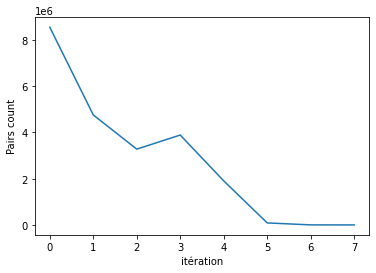

In [ ]:
%python
import networkx as nx
import matplotlib.pyplot as plt
#ccf_naive
pairs = [pair[0] for pair in size_distribution_plot]
iterations = [it[1] for it in size_distribution_plot]
plt.plot(iterations,pairs)
plt.ylabel("Pairs count")
plt.xlabel("itération")



The number of new pairs generated per iteration is the same for both the CCF-Iterate algorithm with secondary sorting and the CCF-Iterate algorithm without secondary sorting, it suggests that the additional overhead introduced by the secondary sorting approach did not significantly impact the generation of new pairs. This could imply that the graph structure or dataset characteristics did not benefit greatly from the secondary sorting optimization, or that other factors may have influenced the performance. Further analysis and experimentation may be needed to determine the exact reason for the similar results.

Out[18]: Text(0.5, 0, 'itération')

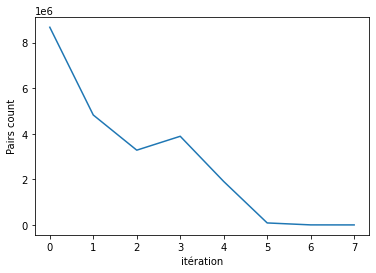

In [ ]:
%python
import networkx as nx
import matplotlib.pyplot as plt
#ccf_stored
pairs_2 = [pair[0] for pair in size_distribution_plot_2]
iterations_2 = [it[1] for it in size_distribution_plot_2]
plt.plot(iterations_2,pairs_2)
plt.ylabel("Pairs count")
plt.xlabel("iteration")


This code generates a comparative table between the CCF naive approach and the CCF Secondary Sorting approach, presenting performance metrics such as the number of iterations and the runtime. The results indicate that both the CCF naive approach and the CCF Secondary Sorting approach required the same number of iterations, suggesting a similar convergence rate in identifying connected components. However, there is a slight difference in runtime, with the CCF Secondary Sorting approach demonstrating a slightly faster execution time compared to the CCF naive approach. This difference may be attributed to the optimization introduced by the secondary sorting technique, which enhances the efficiency of the algorithm's execution. Overall, while both approaches achieved the same outcome in terms of iterations, the secondary sorting approach exhibited slightly better runtime performance, highlighting its effectiveness in reducing computation time.

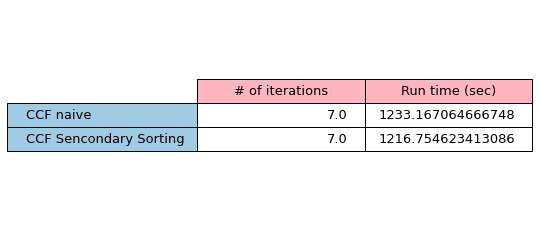

In [ ]:
#Performance comparaison 
#import packages
import pandas as pd
import matplotlib.pyplot as plt

fig, ax =plt.subplots(1,1)
data=[[size_distribution_plot[-1][1],timespent_1],
      [size_distribution_plot_2[-1][1],timespent_2]]
column_labels=["# of iterations", "Run time (sec)"]

#creating a 2-dimensional dataframe out of the given data
df=pd.DataFrame(data,columns=column_labels)

ax.axis('tight') #turns off the axis lines and labels
ax.axis('off') #changes x and y axis limits such that all data is shown

#plotting data
table = ax.table(cellText=df.values,
        colLabels=df.columns,
        rowLabels=["CCF naive","CCF Sencondary Sorting"],
        rowColours =['#A0CBE2'] * 2,
        colColours =['#FFB6C1'] * 2,
        loc="center")
table.set_fontsize(14)
table.scale(1,2)
plt.show()

This code snippet visualizes a graph by iterating through its edges, adding them to a graph object, and then drawing the graph with colored nodes based on uniqueness. We tested it on a small graph.

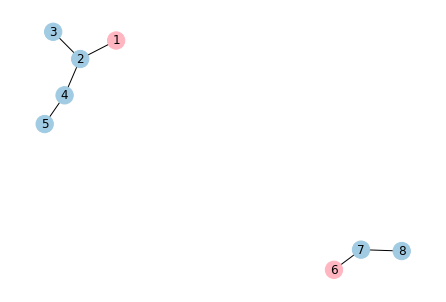

In [ ]:
%python
G = nx.Graph()
for edge in r.collect():
  G.add_edge(edge[0],edge[1])

unique_node = r.map(lambda x : x[1]).distinct().collect()

nx.draw(G,node_color=['#A0CBE2' if node in unique_node else '#FFB6C1' for node in G.nodes()], with_labels=True)
plt.show()

The provided graph represents the distribution of connected component sizes in a given dataset. Each point on the graph corresponds to a connected component, with the x-axis indicating the size (number of nodes) of each component and the y-axis representing the frequency or count of components of that size. The plot reveals that the majority of connected components are relatively small, with a concentration of data points towards the lower end of the size spectrum. This suggests that there are numerous small connected components in the dataset, while larger components are less frequent. Overall, the graph provides insight into the size distribution of connected components within the dataset, highlighting the prevalence of smaller components.


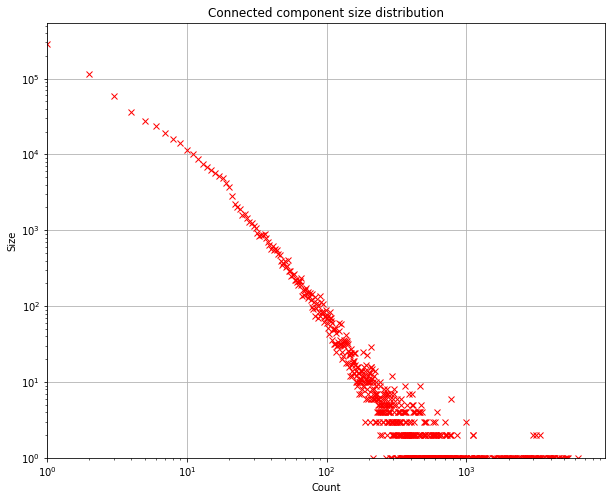

In [ ]:
#Connected component size distribution
plt.figure(figsize=(10,8))
cc = r.map(lambda x: (x[1], x[0])).groupByKey().mapValues(list)
cc = cc.map(lambda x: (len(x[1]), 1))
cc = cc.reduceByKey(lambda x,y: x+y)
X = cc.map(lambda x: x[0]).collect()
Y = cc.map(lambda x: x[1]).collect()
plt.plot(X, Y, 'rx')

plt.xscale("log")
plt.xlabel("Count")
plt.xlim(left=1)  

plt.yscale("log")
plt.ylabel("Size")
plt.ylim(bottom=1)  

plt.title('Connected component size distribution')
plt.grid(True)

CCF Naive and CCF with Secondary Sorting are two variations of the Connected Component Finder algorithm. While CCF Naive follows a straightforward approach, iterating over key-value pairs to identify connected components, CCF with Secondary Sorting enhances performance by incorporating secondary sorting techniques. This optimization reduces the number of iterations required for convergence, leading to improved runtime performance.